In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

from components import *

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [8]:
BATCH_SIZE = 256
INPUT_SIZE = Generator.INPUT_SIZE
REAL_LABEL, FAKE_LABEL = 1, 0
dataloader = get_data_loader(train=True, batch_size=BATCH_SIZE)

In [9]:
netG = Generator().to(device)
netD = Discriminator().to(device)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

G_losses, D_losses = [], []

We update a running average of the model parameters.

This approach can improve the training stability of GANs.

For GANs with non-convex object function, historical averaging may stop models from circling around the equilibrium point and act as a damping force to converge the model.

We add an L2 cost below to the cost function to penalize any model whose parameters are different from the historical average.
<img src='https://miro.medium.com/max/1400/1*GPF-atOVcSTbXN6C8ALqKg.png'>
where θ[i] is the value of the parameters at past time i

In [10]:
base_criterion = nn.BCELoss().to(device)
LAMBD = 0.5
history = dict()


def historical_loss(network, predictions, targets):
    global time_steps

    if network not in history.keys():
        history[network] = (list(), 0)
    sum_parameters, time_steps = history[network]

    loss = base_criterion(predictions, targets)
    for i, param in enumerate(network.parameters()):
        clone_param = param.data.clone()
        if time_steps == 0:
            sum_parameters.append(clone_param)
        else:
            historical_avg = param - (sum_parameters[i].data / time_steps)
            historical_avg = torch.mean(historical_avg ** 2)
            loss += historical_avg
            sum_parameters[i] += clone_param
    loss *= LAMBD
    time_steps += 1
    history[network] = (sum_parameters, time_steps)
    return loss

In [11]:
criterion = historical_loss

In [12]:
def train(num_epochs = 1):

    label_real = torch.full((BATCH_SIZE,), REAL_LABEL, device=device, dtype=torch.float)
    label_fake = torch.full((BATCH_SIZE,), FAKE_LABEL, device=device, dtype=torch.float)

    for epoch in range(num_epochs):
        print('   EPOCH: ', epoch)
        for i, data in enumerate(dataloader, 0):
            # ===========TRAIN_DISCRIMINSTOR============
            netD.zero_grad()
            data_real = data[0].to(device)
            output_real = netD(data_real).view(-1)
            errD_real = criterion(netD ,output_real, label_real)
            errD_real.backward()
            D_x = output_real.mean().item()

            noise = torch.randn(BATCH_SIZE, INPUT_SIZE, 1, 1, device=device)
            data_fake = netG(noise)
            output_fake = netD(data_fake.detach()).view(-1)
            errD_fake = criterion(netD ,output_fake, label_fake)
            errD_fake.backward()
            D_G_z1 = output_fake.mean().item()

            errD = errD_real + errD_fake
            optimizerD.step()

            # ===============TRAIN_GENERATOR===============
            netG.zero_grad()
            output = netD(data_fake).view(-1)
            errG = criterion(netG ,output, label_real)

            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            # Output training stats
            if i % 100 == 0:
                print('[%.3d/%d]   Loss_D: %.4f   Loss_G: %.4f   D(x): %.4f   D(G(z)): %.4f / %.4f'
                      % (i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            G_losses.append(errG.item())
            D_losses.append(errD.item())


## TRAINING PROCESS

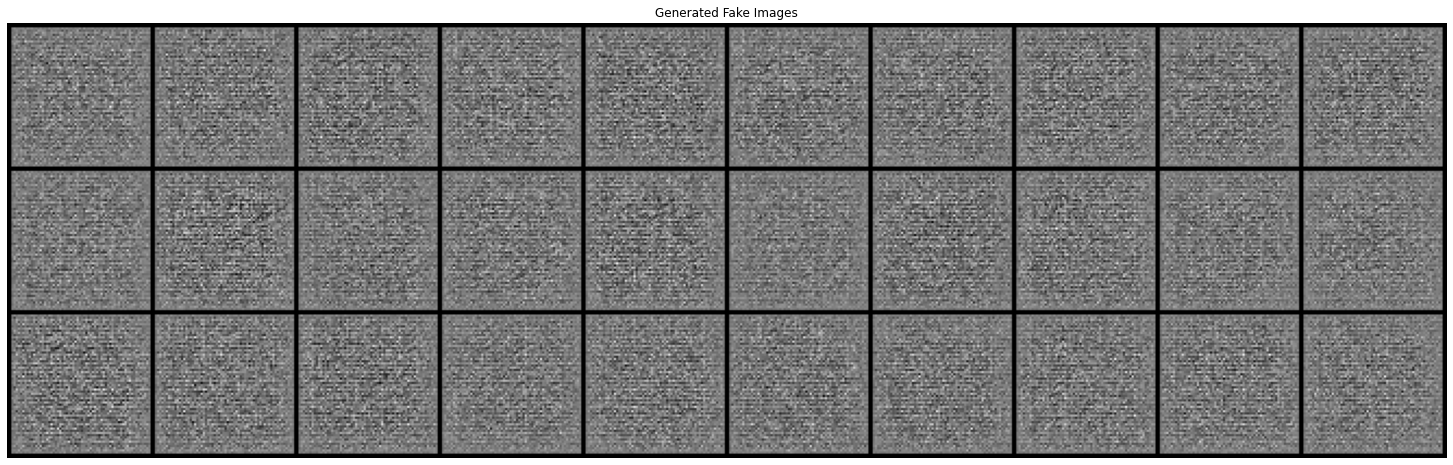

In [7]:
generate_images(netG)

In [13]:
train(num_epochs=10)

   EPOCH:  0
[000/234]   Loss_D: 0.5231   Loss_G: 1.6368   D(x): 0.5904   D(G(z)): 0.2966 / 0.0542
[100/234]   Loss_D: 0.0592   Loss_G: 3.2339   D(x): 0.9460   D(G(z)): 0.0421 / 0.0029
[200/234]   Loss_D: 0.0568   Loss_G: 1.9765   D(x): 0.9245   D(G(z)): 0.0222 / 0.0244
   EPOCH:  1
[000/234]   Loss_D: 0.0650   Loss_G: 2.3449   D(x): 0.9347   D(G(z)): 0.0456 / 0.0140
[100/234]   Loss_D: 0.0530   Loss_G: 1.7636   D(x): 0.9404   D(G(z)): 0.0380 / 0.0431
[200/234]   Loss_D: 0.0565   Loss_G: 1.9456   D(x): 0.9664   D(G(z)): 0.0704 / 0.0297
   EPOCH:  2
[000/234]   Loss_D: 0.1202   Loss_G: 1.5258   D(x): 0.8588   D(G(z)): 0.0601 / 0.0769
[100/234]   Loss_D: 0.8143   Loss_G: 0.7428   D(x): 0.2909   D(G(z)): 0.0014 / 0.3196
[200/234]   Loss_D: 0.0702   Loss_G: 1.5298   D(x): 0.9187   D(G(z)): 0.0495 / 0.0657
   EPOCH:  3
[000/234]   Loss_D: 0.0795   Loss_G: 1.8397   D(x): 0.9651   D(G(z)): 0.1101 / 0.0357
[100/234]   Loss_D: 0.0963   Loss_G: 1.4114   D(x): 0.8698   D(G(z)): 0.0374 / 0.0798
[2

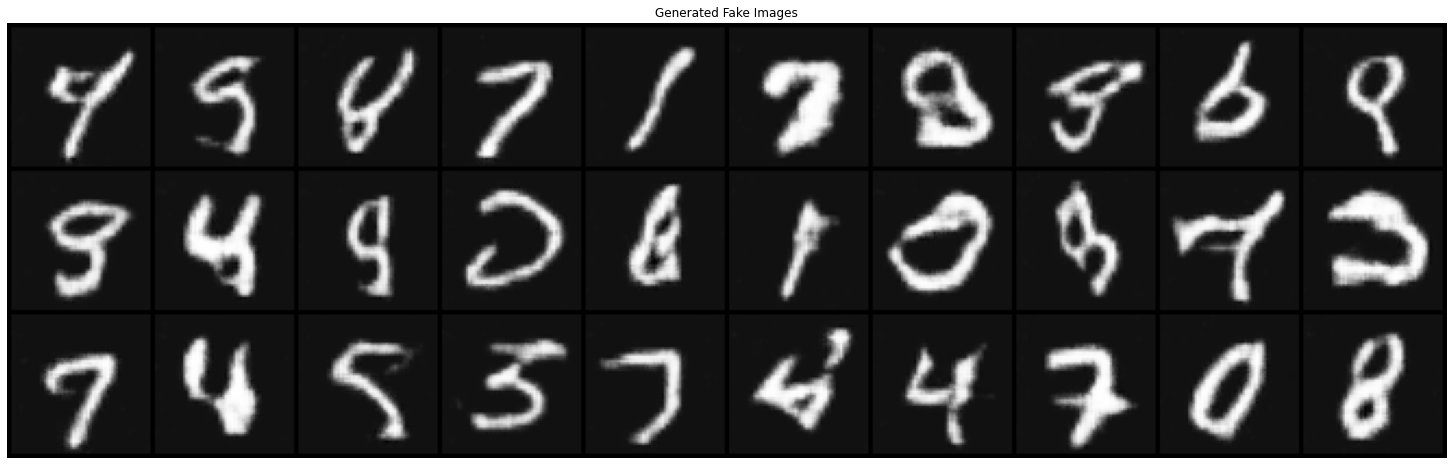

In [14]:
generate_images(netG)

In [15]:
train(num_epochs=10)

   EPOCH:  0
[000/234]   Loss_D: 0.3385   Loss_G: 0.8736   D(x): 0.6140   D(G(z)): 0.1031 / 0.2190
[100/234]   Loss_D: 0.0436   Loss_G: 2.2457   D(x): 0.9724   D(G(z)): 0.0532 / 0.0191
[200/234]   Loss_D: 0.0946   Loss_G: 1.3580   D(x): 0.8957   D(G(z)): 0.0666 / 0.0977
   EPOCH:  1
[000/234]   Loss_D: 0.0353   Loss_G: 1.7963   D(x): 0.9709   D(G(z)): 0.0380 / 0.0449
[100/234]   Loss_D: 0.0157   Loss_G: 2.3774   D(x): 0.9821   D(G(z)): 0.0123 / 0.0157
[200/234]   Loss_D: 1.4048   Loss_G: 0.2978   D(x): 0.1127   D(G(z)): 0.0020 / 0.6045
   EPOCH:  2
[000/234]   Loss_D: 0.1746   Loss_G: 1.4767   D(x): 0.8057   D(G(z)): 0.0930 / 0.0848
[100/234]   Loss_D: 0.0063   Loss_G: 3.2817   D(x): 0.9899   D(G(z)): 0.0016 / 0.0026
[200/234]   Loss_D: 0.6997   Loss_G: 1.8871   D(x): 0.8645   D(G(z)): 0.6085 / 0.0408
   EPOCH:  3
[000/234]   Loss_D: 0.6618   Loss_G: 0.6991   D(x): 0.3601   D(G(z)): 0.0813 / 0.3197
[100/234]   Loss_D: 0.0155   Loss_G: 2.4644   D(x): 0.9858   D(G(z)): 0.0155 / 0.0128
[2

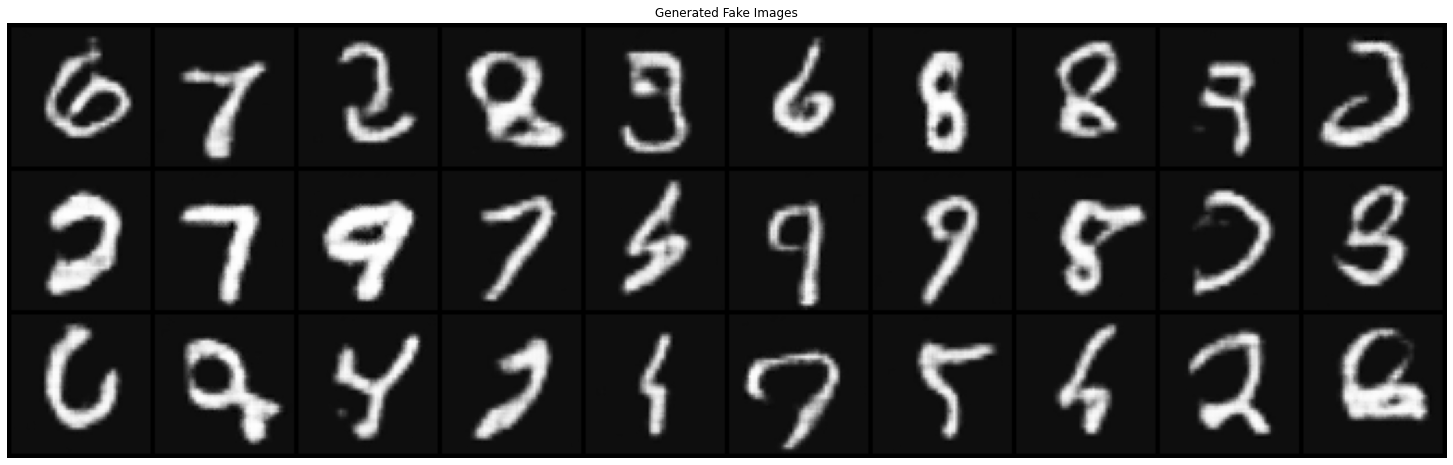

In [16]:
generate_images(netG)

In [17]:
train(num_epochs=10)

   EPOCH:  0
[000/234]   Loss_D: 0.1743   Loss_G: 1.2270   D(x): 0.7795   D(G(z)): 0.0573 / 0.1307
[100/234]   Loss_D: 0.0899   Loss_G: 2.4757   D(x): 0.9698   D(G(z)): 0.1244 / 0.0117
[200/234]   Loss_D: 0.0144   Loss_G: 2.5528   D(x): 0.9865   D(G(z)): 0.0137 / 0.0115
   EPOCH:  1
[000/234]   Loss_D: 0.0256   Loss_G: 2.6522   D(x): 0.9820   D(G(z)): 0.0302 / 0.0088
[100/234]   Loss_D: 0.4447   Loss_G: 0.6152   D(x): 0.5361   D(G(z)): 0.1460 / 0.3624
[200/234]   Loss_D: 0.2611   Loss_G: 0.4227   D(x): 0.6704   D(G(z)): 0.0329 / 0.5267
   EPOCH:  2
[000/234]   Loss_D: 0.1218   Loss_G: 1.7368   D(x): 0.8839   D(G(z)): 0.0906 / 0.0542
[100/234]   Loss_D: 0.9073   Loss_G: 0.4537   D(x): 0.2572   D(G(z)): 0.0009 / 0.4816
[200/234]   Loss_D: 0.0103   Loss_G: 2.3791   D(x): 0.9947   D(G(z)): 0.0138 / 0.0168
   EPOCH:  3
[000/234]   Loss_D: 1.1675   Loss_G: 0.1352   D(x): 0.5968   D(G(z)): 0.5573 / 0.8121
[100/234]   Loss_D: 0.5881   Loss_G: 0.7456   D(x): 0.6875   D(G(z)): 0.5124 / 0.2565
[2

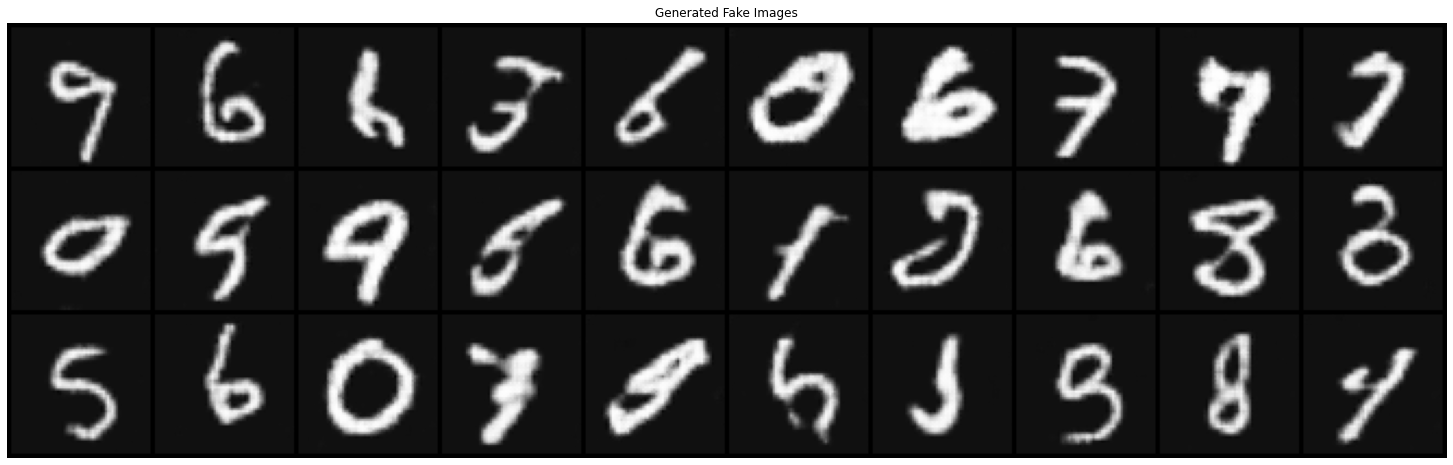

In [18]:
generate_images(netG)

In [19]:
train(num_epochs=10)

   EPOCH:  0
[000/234]   Loss_D: 0.4530   Loss_G: 0.5384   D(x): 0.5857   D(G(z)): 0.2568 / 0.3877
[100/234]   Loss_D: 0.1155   Loss_G: 1.0738   D(x): 0.8517   D(G(z)): 0.0531 / 0.1692
[200/234]   Loss_D: 0.1958   Loss_G: 1.2291   D(x): 0.7677   D(G(z)): 0.0854 / 0.1311
   EPOCH:  1
[000/234]   Loss_D: 0.0511   Loss_G: 2.5051   D(x): 0.9835   D(G(z)): 0.0756 / 0.0118
[100/234]   Loss_D: 0.0124   Loss_G: 2.7973   D(x): 0.9888   D(G(z)): 0.0116 / 0.0076
[200/234]   Loss_D: 0.4915   Loss_G: 0.5950   D(x): 0.6893   D(G(z)): 0.4133 / 0.3472
   EPOCH:  2
[000/234]   Loss_D: 0.2092   Loss_G: 1.8751   D(x): 0.9202   D(G(z)): 0.2576 / 0.0330
[100/234]   Loss_D: 0.0403   Loss_G: 2.7820   D(x): 0.9879   D(G(z)): 0.0619 / 0.0068
[200/234]   Loss_D: 0.0144   Loss_G: 2.9906   D(x): 0.9760   D(G(z)): 0.0024 / 0.0059
   EPOCH:  3
[000/234]   Loss_D: 0.0111   Loss_G: 3.1317   D(x): 0.9973   D(G(z)): 0.0178 / 0.0033
[100/234]   Loss_D: 0.0051   Loss_G: 3.0493   D(x): 0.9954   D(G(z)): 0.0042 / 0.0045
[2

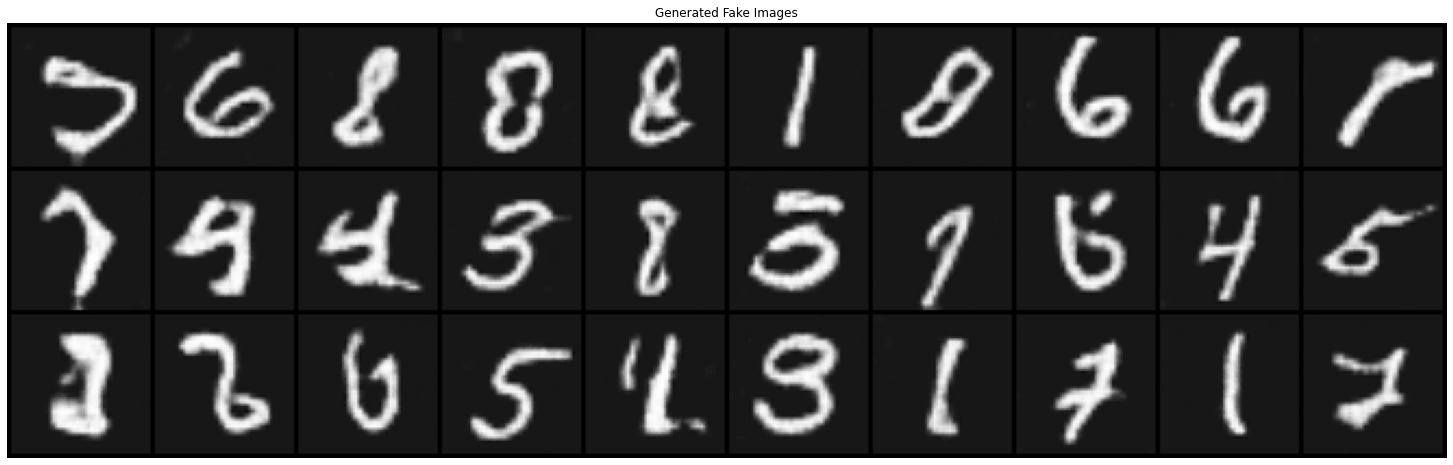

In [20]:
generate_images(netG)

In [21]:
train(num_epochs=10)

   EPOCH:  0
[000/234]   Loss_D: 0.1012   Loss_G: 3.8869   D(x): 0.9965   D(G(z)): 0.1643 / 0.0007
[100/234]   Loss_D: 0.0136   Loss_G: 2.7662   D(x): 0.9957   D(G(z)): 0.0206 / 0.0074
[200/234]   Loss_D: 0.0077   Loss_G: 2.9875   D(x): 0.9898   D(G(z)): 0.0033 / 0.0056
   EPOCH:  1
[000/234]   Loss_D: 0.0053   Loss_G: 3.3269   D(x): 0.9930   D(G(z)): 0.0020 / 0.0027
[100/234]   Loss_D: 0.4169   Loss_G: 0.9692   D(x): 0.7623   D(G(z)): 0.3853 / 0.1880
[200/234]   Loss_D: 0.1060   Loss_G: 1.9005   D(x): 0.8508   D(G(z)): 0.0269 / 0.0458
   EPOCH:  2
[000/234]   Loss_D: 0.0928   Loss_G: 1.7800   D(x): 0.9072   D(G(z)): 0.0733 / 0.0468
[100/234]   Loss_D: 0.0151   Loss_G: 2.6882   D(x): 0.9782   D(G(z)): 0.0059 / 0.0112
[200/234]   Loss_D: 0.0066   Loss_G: 3.4372   D(x): 0.9899   D(G(z)): 0.0012 / 0.0023
   EPOCH:  3
[000/234]   Loss_D: 0.2426   Loss_G: 0.9345   D(x): 0.7868   D(G(z)): 0.1915 / 0.1931
[100/234]   Loss_D: 0.8269   Loss_G: 0.1488   D(x): 0.2650   D(G(z)): 0.0780 / 0.7919
[2

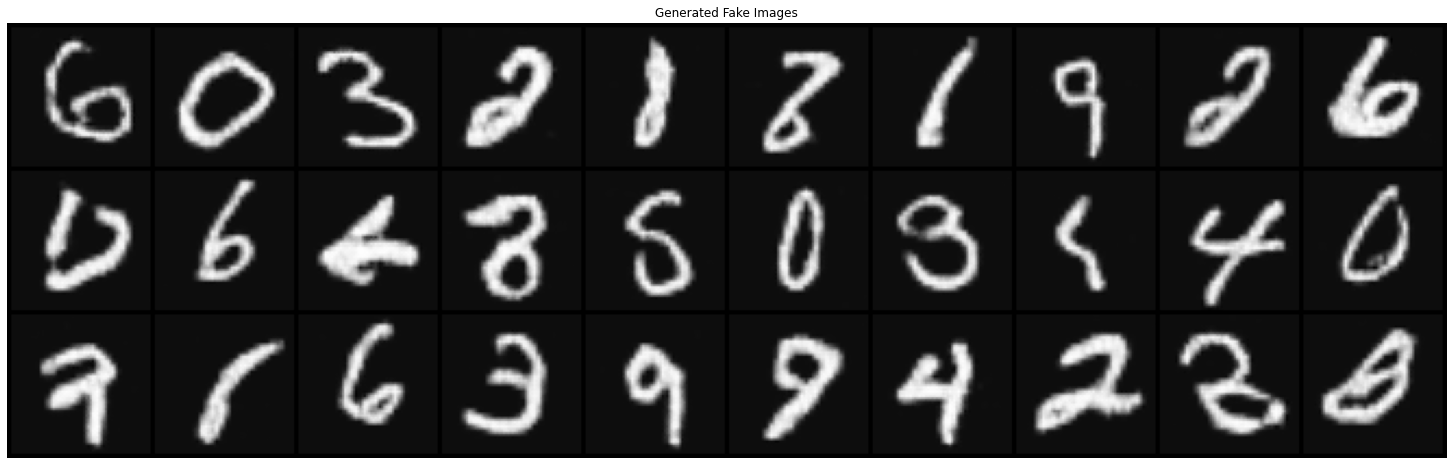

In [22]:
generate_images(netG)

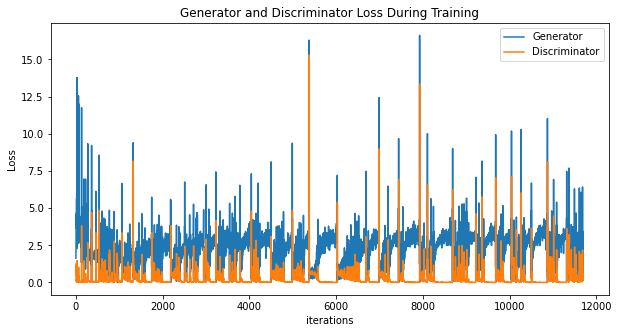

In [34]:
plot_losses(G_losses, D_losses)